# Gumbel softmax/sigmoid

Goal: Understanding details of gumbel-softmax and implement gumbel-sigmoid

- Standard gumbel distribution 으로부터 샘플링하는 코드 자체가 다 제각기 다른데, 그중에서도 pytorch official code 가 제일 이상함. 잘 되는지 확인해보자.

- Cumulative distribution function of gumbel distribution

$$F(x; \mu, \beta) = e^{-e^{-(x-\mu)/\beta}}$$

## Standard gumbel distribution

- Cumulative distribution function

$$F(x)=e^{-e^{-x}}$$

- Probability density function

$$f(x)=e^{-(x+e^{-x})}$$

In [422]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

In [423]:
# https://gist.github.com/yzh119/fd2146d2aeb329d067568a493b20172f
def sample_gumbel(shape, eps=1e-20):
    # Cumultaive distribution 으로부터 역으로 계산해서 샘플링
    U = torch.rand(shape)
    return -(-(U + eps).log() + eps).log()

In [424]:
# https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax
def sample_gumbel2(shape):
    # 대체 무슨 코드인가 했는데, exponential_() 이 exp() 가 아님; e^{-x} 라는 exponential distribution 으로부터 샘플링해주는 함수.
    gumbels = (
        -torch.empty(shape, memory_format=torch.legacy_contiguous_format).exponential_().log()
    )  # ~Gumbel(0,1)
    return gumbels

In [425]:
def sample_gumbel3(shape):
    gumbel = torch.distributions.gumbel.Gumbel(0, 1)
    return gumbel.sample(shape)

In [426]:
N = 1000000

(tensor(0.5788), tensor(1.2838))

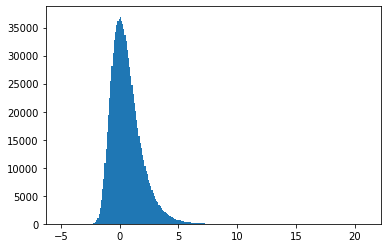

In [427]:
bins = np.arange(-5, 21, 0.1)

r = sample_gumbel([N])
plt.hist(r.numpy(), bins=bins);
r.mean(), r.std()

(tensor(0.5773), tensor(1.2832))

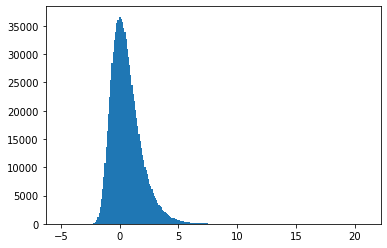

In [428]:
r = sample_gumbel2([N])
plt.hist(r.numpy(), bins=bins);
r.mean(), r.std()

(tensor(0.5781), tensor(1.2828))

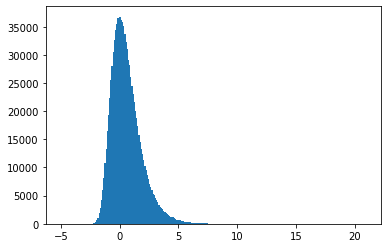

In [429]:
r = sample_gumbel3([N])
plt.hist(r.numpy(), bins=bins);
r.mean(), r.std()

# Sigmoid and Softmax

- gumbel sigmoid 를 eps 없이 짜고 싶담.

In [430]:
t = torch.rand(1, 10)

In [431]:
t.sigmoid()

tensor([[0.7293, 0.5496, 0.6760, 0.6058, 0.6531, 0.6090, 0.5496, 0.6816, 0.6475,
         0.7145]])

In [432]:
# mimic sigmoid using softmax
zt = torch.stack([torch.zeros_like(t), t], dim=-1)
zt.softmax(-1)[:, :, 1]

tensor([[0.7293, 0.5496, 0.6760, 0.6058, 0.6531, 0.6090, 0.5496, 0.6816, 0.6475,
         0.7145]])

In [433]:
def gumbel_sigmoid(logits: torch.Tensor, tau:float = 1, hard: bool = False):
    """Samples from the Gumbel-Sigmoid distribution and optionally discretizes.
    """
    logits = torch.stack([torch.zeros_like(logits), logits], dim=-1)
    return F.gumbel_softmax(logits, tau, hard, dim=-1)[..., -1]

In [434]:
# 이렇게 직접 짤 수도.
def gumbel_sigmoid2(logits: torch.Tensor, tau:float = 1, hard: bool = False):
    """Samples from the Gumbel-Sigmoid distribution and optionally discretizes.
    
    References:
        - https://github.com/yandexdataschool/gumbel_dpg/blob/master/gumbel.py
        - https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax
    """
    gumbels1 = -torch.empty_like(logits).exponential_().log() # ~Gumbel(0,1)
    gumbels2 = -torch.empty_like(logits).exponential_().log() # ~Gumbel(0,1)
    
    gumbels = (logits + gumbels1 - gumbels2) / tau  # ~Gumbel(logits,tau) - ?
    y_soft = gumbels.sigmoid()

    if hard:
        # Straight through.
        y_hard = y_soft.gt(0.5).float()
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft

    return ret

In [435]:
# 검벨 노이즈를 두번 샘플링 해서 빼주는 것과 그냥 하나만 더해주는 게 어떻게 다른가?
# 두번 샘플링 해서 빼면 Logsitic distribution 이 됨. 아래 One-step-more 섹션 참고.
def gumbel_sigmoid3(logits: torch.Tensor, tau:float = 1, hard: bool = False):
    logistic = sample_standard_logistic(logits.shape)

    gumbels = (logits + logistic) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.sigmoid()

    if hard:
        # Straight through.
        y_hard = y_soft.gt(0.5).float()
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft

    return ret

In [436]:
def tostr(tensor):
    return ", ".join(map(lambda x: f"{x:.4f}", tensor.numpy()))

def test(fn, N, ndim, t=None, hard=False):
    if t is None:
        t = torch.rand(ndim) * 5
    s = torch.zeros(ndim)

    print("sig:", tostr(t.sigmoid()))

    for i in range(N):
        r = fn(t, hard=hard)
        s += r

    s /= N
    print("avg:", tostr(s))

In [439]:
N = 50000
ndim = 12
t = torch.randn(ndim) * 3
hard = False

In [443]:
test(gumbel_sigmoid, N, ndim, t=t, hard=hard)

sig: 0.9956, 0.9281, 0.0090, 0.0573, 0.2178, 0.7549, 0.1251, 0.8979, 0.7281, 0.3631, 0.9896, 0.0966
avg: 0.9808, 0.8499, 0.0339, 0.1284, 0.2968, 0.6792, 0.2111, 0.8138, 0.6614, 0.4080, 0.9618, 0.1809


In [444]:
test(gumbel_sigmoid2, N, ndim, t=t, hard=hard)

sig: 0.9956, 0.9281, 0.0090, 0.0573, 0.2178, 0.7549, 0.1251, 0.8979, 0.7281, 0.3631, 0.9896, 0.0966
avg: 0.9800, 0.8513, 0.0346, 0.1275, 0.2974, 0.6802, 0.2114, 0.8138, 0.6586, 0.4071, 0.9618, 0.1787


In [445]:
test(gumbel_sigmoid3, N, ndim, t=t, hard=hard)

sig: 0.9956, 0.9281, 0.0090, 0.0573, 0.2178, 0.7549, 0.1251, 0.8979, 0.7281, 0.3631, 0.9896, 0.0966
avg: 0.9807, 0.8512, 0.0342, 0.1276, 0.2958, 0.6799, 0.2123, 0.8141, 0.6583, 0.4068, 0.9616, 0.1806


## One step more

두 standard gumbel distribution 의 차는 standard logistic distribution 을 따른다고 함 (https://math.stackexchange.com/questions/637929/how-to-show-that-the-difference-of-two-gumbel-distributed-random-variables-follo)

$$X,Y\sim\text{Gumbel}[0,1]$$

then,

$$X-Y\sim\text{Logistic}[0,1]$$

- Cumulative distribution function of Logistic distribution

$$F(x ; \mu, s)=\frac{1}{1+e^{-(x-\mu) / s}}=\frac{1}{2}+\frac{1}{2} \tanh \left(\frac{x-\mu}{2 s}\right)$$

- Standard cumulative distribution function

$$
F(x)=\frac{1}{1+e^{-x}}
$$

In [389]:
from torch.distributions import SigmoidTransform

In [395]:
t = torch.rand(10)
print(t)
SigmoidTransform().inv(t).sigmoid()

tensor([0.9692, 0.7315, 0.6263, 0.3394, 0.6865, 0.0322, 0.2155, 0.8013, 0.6271,
        0.5695])


tensor([0.9692, 0.7315, 0.6263, 0.3394, 0.6865, 0.0322, 0.2155, 0.8013, 0.6271,
        0.5695])

In [396]:
# e^{-x} = 1/F(x) - 1
# x = -log(1/F(x) - 1)


def sample_standard_logistic(shape):
    return SigmoidTransform().inv(torch.rand(shape))

In [401]:
sample_standard_logistic([1, 12])

tensor([[ 6.8093, -2.2592, -0.6496, -1.9989,  2.1684,  2.8180, -0.2385,  0.5564,
          1.5891, -3.1812,  0.3445, -2.3692]])